In [1]:
import os
import tensorflow as tf
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import random
import time
import json
from neural_network import neural_network
from ops import *
from evaluation import evaluation

# Loading Data

In [2]:
# training data
t1_train = np.load('./Dataset/house1/Final/channel_5.npy')
mix_train = np.load('./Dataset/house1/Final/mix.npy')
t2_train = mix_train-t1_train
'''
tmp = scipy.io.loadmat('./Dataset/house1/mix_train.mat')
mix_train = np.transpose(tmp['mix_train'])
tmp = scipy.io.loadmat('./Dataset/house1/source1_train.mat')
t1_train = np.transpose(tmp['source1_train'])
tmp = scipy.io.loadmat('./Dataset/house1/source2_train.mat')
t2_train = np.transpose(tmp['source2_train'])
train_size = mix_train.shape[0]
'''

# test data
'''
tmp = scipy.io.loadmat('./mix_test.mat')
mix_test = np.transpose(tmp['mix_test'])
tmp = scipy.io.loadmat('./source1_test.mat')
t1_test = np.transpose(tmp['source1_test'])
tmp = scipy.io.loadmat('./source2_test.mat')
t2_test = np.transpose(tmp['source2_test'])
test_size = mix_test.shape[0]
'''

"\ntmp = scipy.io.loadmat('./mix_test.mat')\nmix_test = np.transpose(tmp['mix_test'])\ntmp = scipy.io.loadmat('./source1_test.mat')\nt1_test = np.transpose(tmp['source1_test'])\ntmp = scipy.io.loadmat('./source2_test.mat')\nt2_test = np.transpose(tmp['source2_test'])\ntest_size = mix_test.shape[0]\n"

# Setting

In [3]:
# Setting
architecture = np.array([1000, 1000, 1000, 1000, 1000])
batch_size = 50
LR = 0.001
EP = 100
activation_function = tf.contrib.keras.activations.elu
# Initialization
dnn = neural_network(architecture=architecture, batch_size=batch_size, LR=LR, activation_function=activation_function)
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
# Setting for dataset
input_size = 1000
overlap = 500
whole_size = t1_train.shape[0] # the overall length of the energy
t1_train, _ = data_adjust(t1_train, input_size, overlap)
t2_train, _ = data_adjust(t2_train, input_size, overlap)
mix_train, train_size = data_adjust(mix_train, input_size, overlap)

In [4]:
# Restore trained models
#saver = tf.train.Saver()
#saver.restore(sess, "./Models/Energy_Dissagregation.ckpt")

# Training for washing machine

In [5]:
MSE_train = []
MSE_test  = []
total_loss = 0
for ep in range(EP):
    start = time.time()
    # ------------------Training------------------
    shuffle = [i for i in range(train_size)]
    np.random.shuffle(shuffle)
    shuffle = shuffle_append(shuffle, train_size, batch_size)
    
    for idx in range(math.ceil(train_size/batch_size)):
        # input at the currenct iteration
        t1, t2, mix = get_batch(t1_train, t2_train, mix_train, shuffle[idx*batch_size:(idx+1)*batch_size], input_size, overlap)
        
        feed_dict = {
            dnn.mix: mix,
            dnn.t1: t1,
            dnn.t2: t2
        }
        
        # update parameters
        _, loss = sess.run([dnn.train_op, dnn.loss], feed_dict)
        total_loss = total_loss + loss
    total_loss = total_loss/(train_size/batch_size)
    MSE_train.append(total_loss)
    total_loss = 0
    '''
    # ------------------Testing------------------
    for idx in range(int(test_size/batch_size)):
        # input at the currenct iteration
        feed_dict = {
            dnn.mix: mix_test[idx*batch_size:(idx+1)*batch_size-1, :],
            dnn.t1: t1_test[idx*batch_size:(idx+1)*batch_size-1, :],
            dnn.t2: t2_test[idx*batch_size:(idx+1)*batch_size-1, :]
        }
        
        # update parameters
        loss = sess.run(dnn.loss, feed_dict)
        total_loss = total_loss + loss
    total_loss = total_loss/(test_size/batch_size)
    MSE_test.append(total_loss)
    total_loss = 0
    '''
    end = time.time()
    # ------------------Print------------------
    #print('Epoch: ', ep, 'Training Loss: ', MSE_train[-1], 'Testing Loss: ', MSE_test[-1], 'Time duration: ', end-start)
    print('Epoch: ', ep, 'Training Loss: ', MSE_train[-1], 'Time duration: ', end-start)
            
print('----------------End-----------------')

Epoch:  0 Training Loss:  23902502.3556 Time duration:  1.9471487998962402
Epoch:  1 Training Loss:  20578469.7148 Time duration:  1.6383588314056396
Epoch:  2 Training Loss:  19484065.0433 Time duration:  1.6418638229370117
Epoch:  3 Training Loss:  18755572.4501 Time duration:  1.6915664672851562
Epoch:  4 Training Loss:  17756217.1307 Time duration:  1.6453700065612793
Epoch:  5 Training Loss:  18213098.2085 Time duration:  1.6339170932769775
Epoch:  6 Training Loss:  18714660.8034 Time duration:  1.699517011642456
Epoch:  7 Training Loss:  17312238.5895 Time duration:  1.7586863040924072
Epoch:  8 Training Loss:  16924845.9445 Time duration:  1.7281160354614258
Epoch:  9 Training Loss:  16366436.3189 Time duration:  1.7070467472076416
Epoch:  10 Training Loss:  15541798.9028 Time duration:  1.7286007404327393
Epoch:  11 Training Loss:  15449027.2209 Time duration:  1.684023141860962
Epoch:  12 Training Loss:  15566105.8151 Time duration:  1.6788880825042725
Epoch:  13 Training Loss

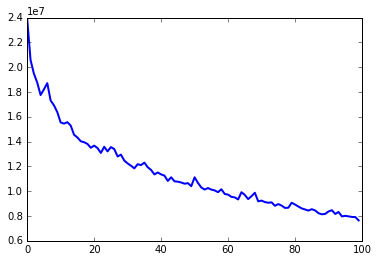

In [6]:
%matplotlib inline
fig = plt.figure()
ax  = fig.add_subplot(1, 1, 1)

ax.plot(MSE_train, linewidth=2)
plt.ion()
ax.plot(MSE_test, linewidth=2)
plt.show()

# Result

In [7]:
y1_train = []
y2_train = []
shuffle = [i for i in range(math.ceil(t1_train.shape[0]/input_size))]
shuffle = shuffle_append(shuffle, math.ceil(t1_train.shape[0]/input_size), batch_size)
for idx in range(math.ceil(train_size/batch_size)):
    _, _, mix = get_batch(t1_train, t2_train, mix_train, shuffle[idx*batch_size:(idx+1)*batch_size], input_size, input_size)
    feed_dict = {dnn.mix: mix}
    y1, y2 = sess.run([dnn.y1, dnn.y2], feed_dict)
    y1_train = y1_train + [y1]
    y2_train = y2_train + [y2]
y1_train, y2_train = unpack(y1_train, y2_train, input_size, whole_size)

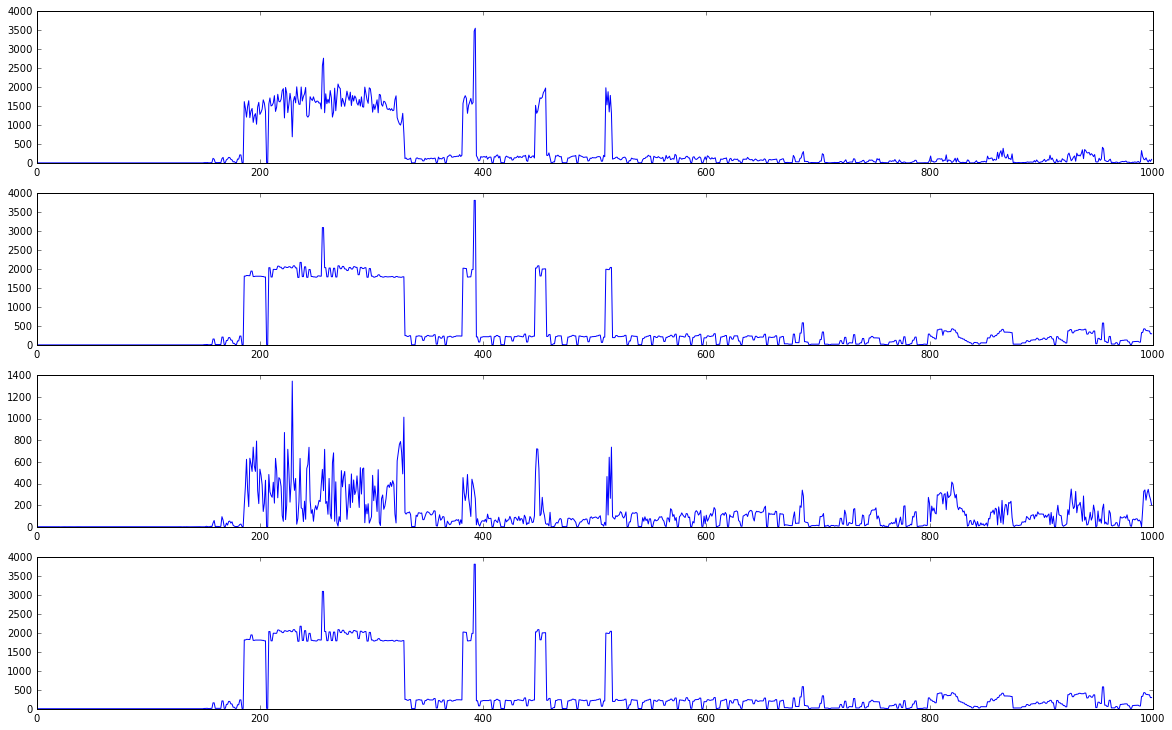

In [8]:
%matplotlib inline
fig = plt.figure()
fig = plt.gcf()
fig.set_size_inches(20, 12.5)
ax  = [fig.add_subplot(4, 1, i) for i in range(1, 5)]
ax[0].plot(y1_train[7000:8000], linewidth=1, label='estimate')
ax[1].plot(t1_train[7000:8000, 1], linewidth=1, label='target1')
ax[2].plot(y2_train[7000:8000], linewidth=1, label='noise')
ax[3].plot(mix_train[7000:8000, 1], linewidth=1, label='mix')

# Saving

In [9]:
# Save the model
saver = tf.train.Saver()
save_path = saver.save(sess, "./Models/Energy_Dissagregation"+".ckpt")

# Save the numpy mat
np.save('./Prediction/channel_5.npy', np.array(y1_train))

# Evaluation

In [12]:
orig = np.load('./Dataset/house1/Final/channel_5.npy')
pred = np.load('./Prediction/channel_5.npy')
aggre = np.load('./Dataset/house1/Final/mix.npy')
RETE, MAE, PTECA = evaluation(orig=orig[:, 1], pred=pred, aggre=aggre[:, 1])
print('Relative error in total energy', RETE)
print('Mean absolute error', MAE)
print('Proportion of total energy correctly assigned', PTECA)

Relative error in total energy 0.349313735608
Mean absolute error 4.80490330777
Proportion of total energy correctly assigned 0.859065336665
